# Current vs Density

In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm import tqdm_notebook

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

### Read data

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

In [3]:
directory = "Z:/Dimers/Simulations/DensityDependence3/"
index_name = "index.dat"

index = pd.read_csv(os.path.join(directory,index_name),sep=" ", names = ["file","packing"])
index.head()

,file,packing
0,Phi_0.01,0.010000
1,Phi_0.04379746835443038,0.043797
2,Phi_0.021265822784810127,0.021266
3,Phi_0.07759493670886075,0.077595
4,Phi_0.03253164556962025,0.032532


In [4]:
h = 3.9 * ureg.um
tilt_angle = 7*ureg.deg
frequency = 3*ureg.Hz

In [5]:
diff_vel = [pd.read_csv(os.path.join(directory,name.file+"_vupdown.dat"), sep="\t",index_col = 0)
            for i,name in tqdm_notebook(index.loc[:].iterrows())]

In [6]:
diff_vel_pd = pd.concat(diff_vel, keys = index.index, names=["file"])
diff_vel_pd.loc[:,"packing"] = index.loc[diff_vel_pd.index.get_level_values("file")].packing.values
diff_vel_pd["plane"] = diff_vel_pd.index.get_level_values("plane")
diff_vel_pd = diff_vel_pd.set_index(["packing","plane"])
diff_vel_pd.head()

x         y
packing  plane                    
0.010000 down  -0.005588  0.008828
0.043797 down   0.005599  0.004297
0.021266 down   0.000516 -0.010277
0.077595 down  -0.008814 -0.000400
         up    -0.312785  3.433837

In [7]:
d = 2.8
freq = frequency.magnitude

def calc_current(series):
    phi = series.index.get_level_values("packing").unique().values[0]
    factor = freq*d*np.sqrt(np.pi/np.sqrt(3)/phi)
    
    if any(series.index.get_level_values("plane")=="up") & \
            any(series.index.get_level_values("plane")=="down"):
        
        out = series.loc[idx[:,"up"],:].reset_index(level=1,drop=True) - \
            series.loc[idx[:,"down"],:].reset_index(level=1,drop=True)

        return pd.DataFrame(data = [np.sqrt(out.x.values**2+out.y.values**2)/(factor)], columns = ["I"])
    else:
    
        return pd.DataFrame(data = [series.index.get_level_values("packing").unique()*0], columns = ["I"])
    

In [8]:
current = diff_vel_pd.groupby("packing").apply(calc_current).reset_index(level=1,drop=True)

In [9]:
current.to_csv("current_vs_density.dat",sep="\t")

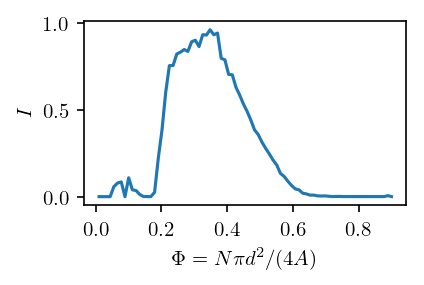

In [10]:
fig = plt.figure(figsize=(3,2))
plt.plot(current.index, current.I)
plt.xlabel(r"$\Phi = N\pi d^2 / (4A)$")
plt.ylabel(r"$I$")
fig.tight_layout()
fig.savefig('current_jamming.pdf', pad_inches = 0, bbox_inches = "tight")